In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import dxchange
from scipy import ndimage
import sys
import ptychocg as pt

if __name__ == "__main__":
    igpu = 0
    cp.cuda.Device(igpu).use()  # gpu id to use

    # set cupy to use unified memory
    pool = cp.cuda.MemoryPool(cp.cuda.malloc_managed)
    cp.cuda.set_allocator(pool.malloc)
    # set cupy to use unified memory
    pool = cp.cuda.MemoryPool(cp.cuda.malloc_managed)
    cp.cuda.set_allocator(pool.malloc)

    # sizes
    n = 600  # horizontal size
    nz = 276  # vertical size
    ntheta = 2  # number of projections
    nscan = 1000  # number of scan positions [max 5706 for the data example]
    nprb = 128  # probe size
    ndetx = 128  # detector x size
    ndety = 128  # detector y size
    ptheta = 2  # number of angular partitions for simultaneous processing in ptychography

    # read probe
    prb0 = cp.zeros([ntheta, nprb, nprb], dtype='complex64')
    prbamp = cp.array(dxchange.read_tiff(
        'model/prbamp.tiff').astype('float32'))
    prbang = cp.array(dxchange.read_tiff(
        'model/prbang.tiff').astype('float32'))
    prb0[0] = prbamp*cp.exp(1j*prbang)

    # read scan positions
    scan = cp.ones([2, ntheta, nscan], dtype='float32')
    scan[:, 0] = cp.load('model/coords.npy')[:, :nscan].astype('float32')

    # read object
    psi0 = cp.ones([ntheta, nz, n], dtype='complex64')
    psiamp = cp.array(dxchange.read_tiff('model/initpsiamp.tiff').astype('float32'))
    psiang = cp.array(dxchange.read_tiff('model/initpsiang.tiff').astype('float32'))
    psi0[0] = psiamp*cp.exp(1j*psiang)
        # Class gpu solver
    with pt.CGPtychoSolver(nscan, nprb, ndetx, ndety, ntheta, nz, n, ptheta, igpu) as slv:
        # Compute data
        data = slv.fwd_ptycho_batch(psi0, scan, prb0)

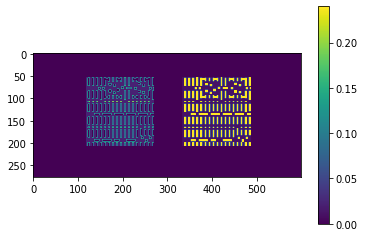

In [13]:
plt.figure()
plt.imshow(np.imag(psi0[0].get()))
plt.colorbar()

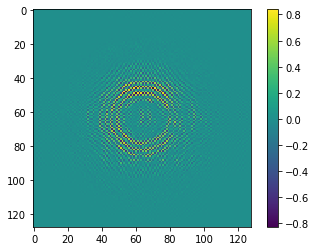

In [18]:
plt.figure()
plt.imshow(np.fft.fftshift(data.real[0,0]))
plt.colorbar()